In [1]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Mounted at /content/drive


In [ ]:
!pip install contractions
!cp -r '$root/utils' .

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle

from sklearn.metrics import f1_score, accuracy_score

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, InputLayer, Embedding, GRU, LSTM, Dropout
from tensorflow.keras.layers import Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from utils.preprocessing import WordEmbeddings
from utils.evaluation import plot_history, evaluate, show_errors

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

# prepare data

In [6]:
raw_data = pickle.load(open(root+'raw_data_0604', 'rb'))

In [7]:
vocab_size = 10000
input_dim = vocab_size + 2 # one for padding, one for oov token

In [8]:
data = pickle.load(open(root+'preprocessed_data_0604', 'rb'))

In [9]:
maxlen = int(data['X_train'].str.split().str.len().quantile(0.9))
maxlen_par = int(data['X_train_par'].str.split().str.len().quantile(0.9))

In [10]:
tokenizer_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen, standardize=None)
tokenizer_layer.adapt(data['X_train'])

In [31]:
tokenizer_par_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen_par, standardize=None)
tokenizer_par_layer.adapt(data['X_train_par'])

# no context

## non-pretrained embeddings
25.03.2022

In [23]:
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    tokenizer_layer,
    Embedding(input_dim=input_dim, output_dim=100, input_length=maxlen,
              mask_zero=True, embeddings_regularizer=L1L2(l1=5e-6, l2=5e-6)),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 121s 20ms/step - loss: 0.6096 - accuracy: 0.7080 - val_loss: 0.5924 - val_accuracy: 0.7232
Epoch 2/50
6002/6002 [==============================] - 117s 20ms/step - loss: 0.5939 - accuracy: 0.7245 - val_loss: 0.5843 - val_accuracy: 0.7328
Epoch 3/50
6002/6002 [==============================] - 117s 19ms/step - loss: 0.5885 - accuracy: 0.7314 - val_loss: 0.5825 - val_accuracy: 0.7356
Epoch 4/50
6002/6002 [==============================] - 117s 20ms/step - loss: 0.5853 - accuracy: 0.7349 - val_loss: 0.5806 - val_accuracy: 0.7384
Epoch 5/50
6002/6002 [==============================] - 138s 23ms/step - loss: 0.5834 - accuracy: 0.7384 - val_loss: 0.5784 - val_accuracy: 0.7416
Epoch 6/50
6002/6002 [==============================] - 143s 24ms/step - loss: 0.5822 - accuracy: 0.7411 - val_loss: 0.5792 - val_accuracy: 0.7422
Epoch 7/50
6002/6002 [==============================] - 118s 20ms/step - loss: 0.5814 - accuracy: 0.7428 - val_loss: 0

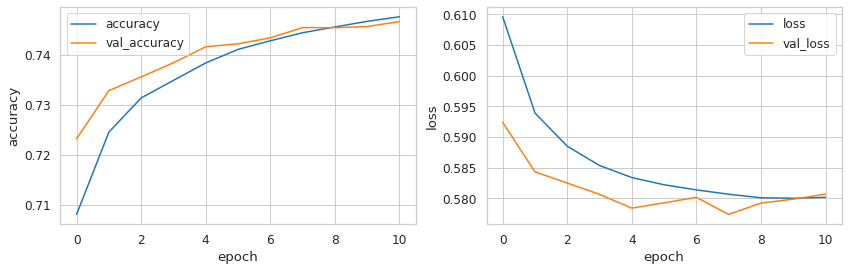

In [24]:
plot_history(fit)

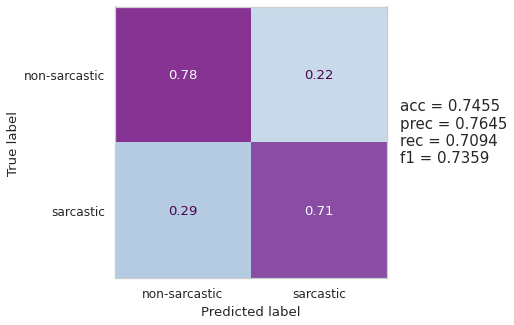

In [25]:
evaluate(model, data['X_val'], data['y_val'])

In [26]:
show_errors(model, raw_data['X_val'].values, data['X_val'], data['y_val'])

False negatives:
---------------------------
Great picture quality for ww1 era, or this must be a problem that exists also outside of that time.
Probably because its: * Not Javascript * Not Rust * Not functional language of choice * Not opinionated enough * Actually useful
Link?
until he corpthefted the german JF services
If optic doesn't win, I'll reset my stats at level 1000

False positives:
---------------------------
Oh I know, I just mean't her normal scenes The blu ray is awesome
Good thing we have Varane :D
Coming to Flint in 2099!
In a COD like Arab accent right?
Found the oinker


In [27]:
model.save(root+'models/gru_non_pretrained')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_non_pretrained/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_non_pretrained/assets


## pretrained embeddings
08.04.2022

### 100d

In [11]:
vec_len = 100
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_layer.get_vocabulary(), root=root)

coverage: 0.9813


In [12]:
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    tokenizer_layer,
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6)),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 132s 20ms/step - loss: 0.9235 - accuracy: 0.7049 - val_loss: 0.6427 - val_accuracy: 0.7277
Epoch 2/50
6002/6002 [==============================] - 122s 20ms/step - loss: 0.6154 - accuracy: 0.7291 - val_loss: 0.5909 - val_accuracy: 0.7360
Epoch 3/50
6002/6002 [==============================] - 121s 20ms/step - loss: 0.5870 - accuracy: 0.7363 - val_loss: 0.5757 - val_accuracy: 0.7409
Epoch 4/50
6002/6002 [==============================] - 122s 20ms/step - loss: 0.5764 - accuracy: 0.7412 - val_loss: 0.5709 - val_accuracy: 0.7435
Epoch 5/50
6002/6002 [==============================] - 119s 20ms/step - loss: 0.5716 - accuracy: 0.7447 - val_loss: 0.5686 - val_accuracy: 0.7453
Epoch 6/50
6002/6002 [==============================] - 121s 20ms/step - loss: 0.5684 - accuracy: 0.7476 - val_loss: 0.5675 - val_accuracy: 0.7471
Epoch 7/50
6002/6002 [==============================] - 120s 20ms/step - loss: 0.5669 - accuracy: 0.7500 - val_loss: 0

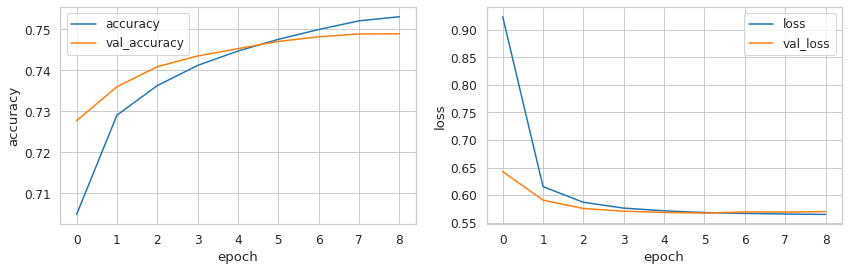

In [13]:
plot_history(fit)

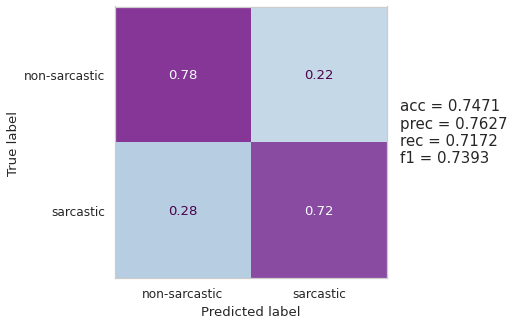

In [14]:
evaluate(model, data['X_val'], data['y_val'])

In [15]:
show_errors(model, raw_data['X_val'].values, data['X_val'], data['y_val'])

False negatives:
---------------------------
What about pulling an off-banner BSB?
HE WAS A GOOD BOY!
At an Apple store in September of 2014.
Louis Vuitton jerseys?
Poor TSM.

False positives:
---------------------------
Yeah if he can play in that form for a whole season if we sign him next year!
That's a quality video right there
Whats preventing someone who needs expensive long term care from moving to any of the other 60 countries on earth with universal healthcare?
What does "LP" mean?
Rational conversation = circlejerk?


In [17]:
model.save(root+'models/gru')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/gru/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/gru/assets


In [18]:
y_pred = model.predict(data['X_val'])

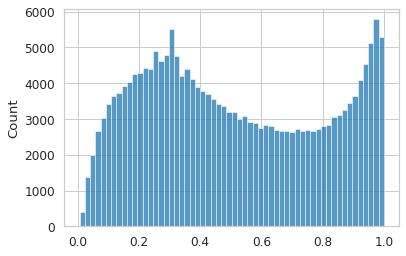

In [19]:
sns.histplot(x=y_pred.flatten());

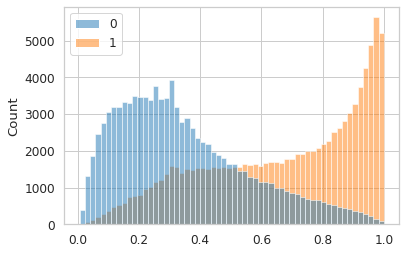

In [20]:
sns.histplot(x=y_pred.flatten(), hue=data['y_val']);

In [21]:
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(data['y_val'], y_pred > thr) for thr in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold, round(np.max(f1_scores), 4)

(0.38, 0.753)

In [22]:
thresholds = np.arange(0, 1, 0.01)
acc_scores = [accuracy_score(data['y_val'], y_pred > thr) for thr in thresholds]
best_threshold = thresholds[np.argmax(acc_scores)]
best_threshold, round(np.max(acc_scores), 4)

(0.52, 0.7476)

### 300d

In [40]:
vec_len = 300
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_layer.get_vocabulary(), root=root)

coverage: 0.9813


In [42]:
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    tokenizer_layer,
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6)),
    GRU(300, dropout=0.4),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 124s 20ms/step - loss: 1.0095 - accuracy: 0.7139 - val_loss: 0.6435 - val_accuracy: 0.7315
Epoch 2/50
6002/6002 [==============================] - 120s 20ms/step - loss: 0.6254 - accuracy: 0.7355 - val_loss: 0.6103 - val_accuracy: 0.7415
Epoch 3/50
6002/6002 [==============================] - 117s 20ms/step - loss: 0.6095 - accuracy: 0.7440 - val_loss: 0.6066 - val_accuracy: 0.7459
Epoch 4/50
6002/6002 [==============================] - 118s 20ms/step - loss: 0.6052 - accuracy: 0.7500 - val_loss: 0.6064 - val_accuracy: 0.7485
Epoch 5/50
6002/6002 [==============================] - 118s 20ms/step - loss: 0.6039 - accuracy: 0.7550 - val_loss: 0.6097 - val_accuracy: 0.7493
Epoch 6/50
6002/6002 [==============================] - 122s 20ms/step - loss: 0.6042 - accuracy: 0.7595 - val_loss: 0.6173 - val_accuracy: 0.7498
Epoch 7/50
6002/6002 [==============================] - 117s 20ms/step - loss: 0.6058 - accuracy: 0.7632 - val_loss: 0

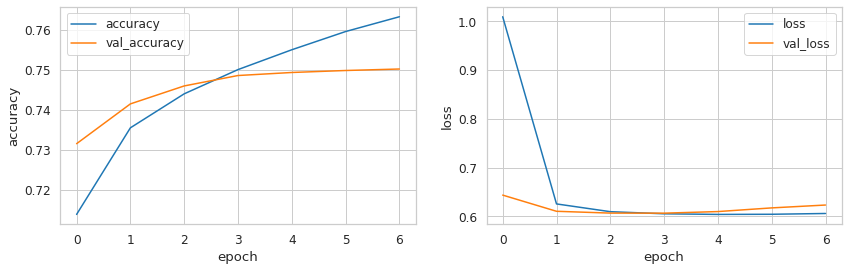

In [43]:
plot_history(fit)

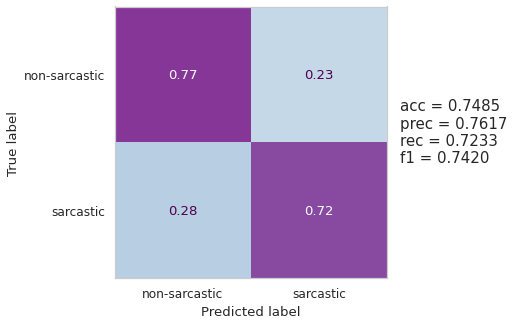

In [44]:
evaluate(model, data['X_val'], data['y_val'])

In [45]:
model.save(root+'models/gru_300d')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/gru_300d/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/gru_300d/assets


# context
08.04.2022

In [32]:
vec_len = 100
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_layer.get_vocabulary(), root=root)
emb_matrix_parent = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_par_layer.get_vocabulary(), root=root)

coverage: 0.9813
coverage: 0.9888


In [33]:
train_data = {'comment': data['X_train'], 'parent': data['X_train_par']}
val_data = {'comment': data['X_val'], 'parent': data['X_val_par']}

In [34]:
def build_rnn(tok_layer, embedding_matrix, maxlen, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(tok_layer)
    x = GRU(100, dropout=0.4)(x)

    return x

In [35]:
comment_input =  Input(shape=(1,), name='comment', dtype=tf.string)
parent_input = Input(shape=(1,), name='parent', dtype=tf.string)

tokenize_comment = tokenizer_layer(comment_input)
tokenize_parent = tokenizer_par_layer(parent_input)

comment_rnn = build_rnn(tokenize_comment, emb_matrix_comment, maxlen, reg=3e-6)
parent_rnn = build_rnn(tokenize_parent, emb_matrix_parent, maxlen_par, reg=3e-6)

x = Concatenate()([comment_rnn, parent_rnn])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_data, data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 230s 37ms/step - loss: 1.3032 - accuracy: 0.6975 - val_loss: 0.6651 - val_accuracy: 0.7309
Epoch 2/50
6002/6002 [==============================] - 225s 37ms/step - loss: 0.6342 - accuracy: 0.7293 - val_loss: 0.5992 - val_accuracy: 0.7393
Epoch 3/50
6002/6002 [==============================] - 224s 37ms/step - loss: 0.5986 - accuracy: 0.7377 - val_loss: 0.5813 - val_accuracy: 0.7445
Epoch 4/50
6002/6002 [==============================] - 222s 37ms/step - loss: 0.5866 - accuracy: 0.7436 - val_loss: 0.5749 - val_accuracy: 0.7469
Epoch 5/50
6002/6002 [==============================] - 221s 37ms/step - loss: 0.5817 - accuracy: 0.7470 - val_loss: 0.5752 - val_accuracy: 0.7499
Epoch 6/50
6002/6002 [==============================] - 220s 37ms/step - loss: 0.5790 - accuracy: 0.7502 - val_loss: 0.5733 - val_accuracy: 0.7503
Epoch 7/50
6002/6002 [==============================] - 214s 36ms/step - loss: 0.5771 - accuracy: 0.7532 - val_loss: 0

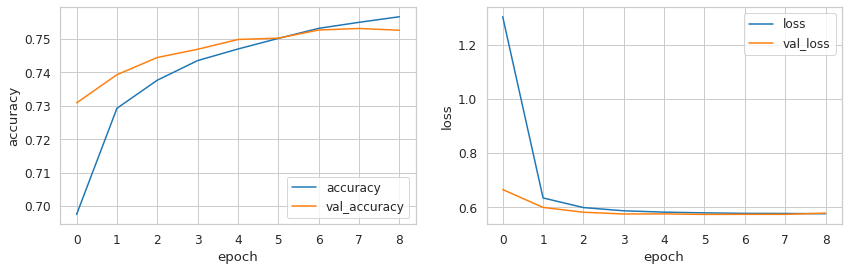

In [36]:
plot_history(fit)

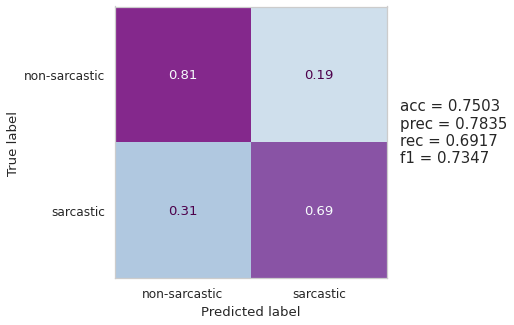

In [37]:
evaluate(model, (data['X_val'], data['X_val_par']), data['y_val'])

In [38]:
show_errors(model, raw_data['X_val'].values, (data['X_val'], data['X_val_par']),
            data['y_val'], X_parents=raw_data['X_val_par'].values)

False negatives:
---------------------------
parent: Taking his joke a little to heart there Mr defensive.
comment: I have an online persona to maintain, man.

parent: New 1898 M91 purchase.
comment: Awesome rifle, great markings, but you're really stretching the meaning of the term new.

parent: Some provinces also prohibit the possession of body armor to civilians, so you should check that as well. NS and BC are two I think that prohibit it.
comment: Well damn, looks like I'm not gunna be on the frontlines of WW III

parent: That's 2 of the 4 200+ delegate states we're dominating. New York should be a Clinton Stronghold and Cali will break even at absolute worst. Where's Bernie's path to the nomination again?
comment: A political revolution.

parent: I think my $15 purchase was worth it
comment: Where did you get a z3 coupe for $15?


False positives:
---------------------------
parent: he and thousand other people are going to get banned
comment: Will GradeAUnderA be banned too?

pa

In [39]:
model.save(root+'models/context_rnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_rnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_rnn/assets
